# Trading Earnings Volatility

## Background

Quarterly earning announcements can cause potentially extreme moves in individual equities as companies under/over perform relative to expectation. These are previously announced events with known times, giving both day traders and large institutions the opportunity to place volatility and directional bets in the options marketplace, capitalizing on market reaction and the sentiment to the report.

To highlight this, we can look at the recent underlying volatility surrounding AMZN and GOOG earnings at the start of 2022, with Alphabet reporting after the market close on 2/1 and AMZN reporting after the market close on 2/2.

GOOG rallied from 2757 to 2960, a gain of 7.3% between the earnings report and the close on 2/2. (GOOGL very similar performance)
Amazon dropped from 3012 to 2776, losing more than 8% between the earnings report and the close on 2/3.

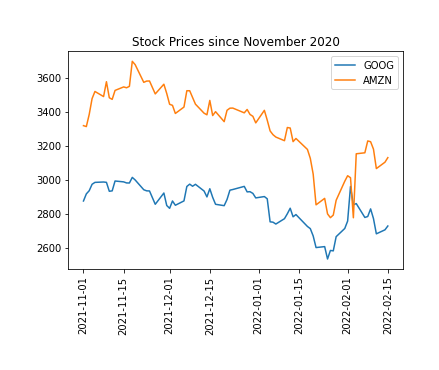

In [1]:
from IPython.display import Image
Image('GOOG_AMZN.png')

## Hypothesis

Stocks experience higher than average realized volatility around quarterly earnings announcements.


The average realized volatility of an individual equity stock through its historical earnings reports relative to its baseline performance is predictive of how much we would expect it to move on an upcoming earnings press release.


If the shortest dated at the money options for an issuer is priced on an implied volatility higher than our prediction for realized volatility going into an earnings, there is a positive expected value in selling the at the money straddle. If the straddle is priced below our prediction for realized volatility, there is a positive expected value position in buying the straddle. 


## Data

We will be using the WRDS OptionsMetrics database to get our data. Specifically, 'OptionMetrics - Historical Volatility' and 'OptionMetrics - Option Prices'.

### Required:
1. Historical earnings dates
2. Daily realized volatility calculations
3. Daily option implied volatilities
4. Daily market close bid/ask prices for the nearest term 50d call and put option

### May Want to Consider:
5. Daily option volumes
6. Earnings data vs expectations

## Strategy Execution

Select a subset of companies that we expect would be a good candidate for this volatility trading strategy. We will select stocks with liquid options markets with earnings announcements that have sparked increased options trading speculation. We also need to select companies that have enough of an earnings history to form a prediction.

For each stock selected:
    1. Compare realized volatility on and the day after earnings announcements to their average realized volatility in the training data set
    2. Calculate an expectation for realized volatility for the future earnings dates in a testing data set and compare it to the implied volatility of the at the money straddle in the day's preceeding the earnings dates.
    3. Construct a sizing curve depending on the difference between implied volatility vs expected realized volatility. Depending on the difference, trade up to 10k notional buying or selling the at the money straddle at the close price BBO.
    4. Close out our straddle position T+1 after earnings date.
    


## Analysis and Data

In [2]:
import quandl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
quandl.ApiConfig.api_key = 'bULWv51MebBBGL56KGys'

#### Select historical adjusted close prices for companies with liquid options markets

In [3]:
#Our option price data ends on 12/31/20 so we will end our analysis on that date.
start = '2015-01-01'
end = '2020-12-31'

tickers = ['GOOG', 'AMZN', 'SNAP', 'MSFT', 'FB', 'TSLA', 'NVDA', 'JPM', 'AVGO', 'VZ']

adj_close = quandl.get_table("QUOTEMEDIA/PRICES", 
                        ticker = tickers,  
                        qopts = { 'columns': ['ticker', 'date', 'adj_close']},  
                        date = { 'gte': start, 'lte': end}, 
                        paginate = True)

adj_close.head()

,ticker,date,adj_close
None,,,
0,VZ,2020-12-31,55.537089
1,VZ,2020-12-30,54.960449
2,VZ,2020-12-29,55.593808
3,VZ,2020-12-28,55.754511
4,VZ,2020-12-24,55.622167


#### 

### Financial statement filing date

In [4]:
# earnings dates (FC/FILING_DATE)
zacks_fc = quandl.get_table('ZACKS/FC', 
                    per_end_date = { 'gte': start, 'lte': end },
                    ticker = tickers, 
                    paginate=True)

In [5]:
# quarterly report filing dates
filing_dates = zacks_fc[zacks_fc['per_type'] == 'Q'][['ticker', 'filing_date']]
filing_dates

,ticker,filing_date
None,,
6,AMZN,2015-04-24
7,AMZN,2015-07-24
8,AMZN,2015-10-23
9,AMZN,2016-01-29
10,AMZN,2016-04-29
...,...,...
292,VZ,2020-02-21
293,VZ,2020-04-27
294,VZ,2020-07-28


#### Historical option data

In [6]:
# this is limited to options with expiry less than 15 days from current date.
option_data = pd.read_csv('data/OptionMetrics.csv.gz', sep = ',')

In [7]:
# match date format of quandl data
option_data['date'] = option_data.apply(lambda row: row.date.replace('/', '-', 2), axis = 1)
option_data['exdate'] = option_data.apply(lambda row: row.exdate.replace('/', '-', 2), axis = 1)

In [8]:
# strike_price = strike * 1000
option_data.head()

,date,exdate,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,delta,optionid,ticker,index_flag,issuer,exercise_style
0,2015-01-02,2015-01-09,C,235000,71.90,75.55,0,0.919228,0.986198,106179177,AMZN,0,AMAZON.COM INC.,A
1,2015-01-02,2015-01-09,C,240000,67.00,70.85,0,0.955372,0.975301,106179178,AMZN,0,AMAZON.COM INC.,A
2,2015-01-02,2015-01-09,C,245000,61.85,65.35,0,0.695843,0.992689,106134398,AMZN,0,AMAZON.COM INC.,A
3,2015-01-02,2015-01-09,C,250000,57.15,60.45,0,0.771536,0.978447,106134399,AMZN,0,AMAZON.COM INC.,A
4,2015-01-02,2015-01-09,C,255000,52.00,55.45,0,0.673865,0.981649,106134400,AMZN,0,AMAZON.COM INC.,A


### Analysis

In [9]:
# create rolling realized vol from adj_close df

close_volatility = pd.DataFrame() 

for t in adj_close.ticker.unique():
    df = adj_close[adj_close['ticker'] == t]
    df = (df['adj_close'].rolling(7).std() * np.sqrt(252)) / df['adj_close']
    close_volatility = pd.concat([close_volatility, df], axis = 0)
    

close_volatility = close_volatility.rename(columns = {0: "vola_1wk"})
close_volatility = pd.concat([adj_close, close_volatility], axis = 1)
close_volatility.tail()

,ticker,date,adj_close,vola_1wk
14561,AMZN,2015-01-08,300.46,0.232995
14562,AMZN,2015-01-07,298.42,0.242654
14563,AMZN,2015-01-06,295.29,0.165570
14564,AMZN,2015-01-05,302.19,0.192035
14565,AMZN,2015-01-02,308.52,0.280981


### Sample Analysis: AMZN in week leading up to and following 2020-10-30 earnings report

In [10]:
def DataRetriever(stockTicker, start, end):
    options = pd.DataFrame(option_data[option_data['ticker'] == stockTicker])
    close = pd.DataFrame(close_volatility[close_volatility['ticker'] == stockTicker])
    filing = filing_dates[filing_dates['ticker'] == stockTicker]
    close['date'] = pd.to_datetime(close['date'])
    close = close.set_index('date')
    close_1wk = close.loc[start : end]
    close_1wk = close_1wk.iloc[::-1]
    options = options.set_index('date')
    opt_1wk = options.loc[start : end]
    return opt_1wk, close_1wk

In [11]:
def GetATMs(df):
    call_d, put_d = {}, {}

    for d in df.index.unique():
        call_i = (abs(df.loc[d]['delta'] - 0.5)).argmin()
        put_i = (abs(df.loc[d]['delta'] + 0.5)).argmin()
        call_d[d] = df.loc[d].iloc[call_i]
        put_d[d] = df.loc[d].iloc[put_i]

    calls = pd.DataFrame(call_d).transpose()
    puts = pd.DataFrame(put_d).transpose()  

    calls.index = pd.to_datetime(calls.index)
    puts.index = pd.to_datetime(puts.index)

    return calls, puts   

def CreateVisual(ticker, closeVols, calls, puts):
    calls['impl_volatility'].plot(legend=True)
    plt.title('{} Implied vs Realized Volatility'.format(ticker))
    # puts['impl_volatility'].plot(legend=True)
    closeVols['vola_1wk'].plot(legend=True)
    plt.ylabel('Volatility')
    plt.show()


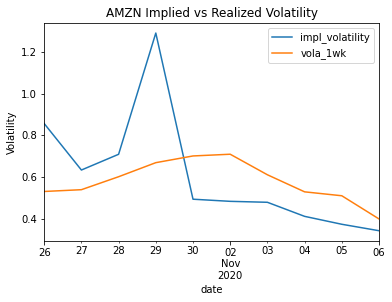

In [24]:
data, closeVols = DataRetriever('AMZN', '2020-10-26', '2020-11-06')
calls, puts = GetATMs(data)
CreateVisual('AMZN', closeVols, calls, puts)

In [25]:
calls

,exdate,cp_flag,strike_price,best_bid,best_offer,volume,impl_volatility,delta,optionid,ticker,index_flag,issuer,exercise_style
2020-10-26,2020-10-30,C,3220000,108.3,109.0,1948,0.857107,0.500013,135921765,AMZN,0,AMAZON.COM INC.,A
2020-10-27,2020-11-06,C,3305000,128.05,129.45,27,0.633659,0.499475,136289535,AMZN,0,AMAZON.COM INC.,A
2020-10-28,2020-11-06,C,3185000,129.45,130.9,178,0.709346,0.497233,136222927,AMZN,0,AMAZON.COM INC.,A
2020-10-29,2020-10-30,C,3220000,81.5,83.2,1548,1.292406,0.49702,135921765,AMZN,0,AMAZON.COM INC.,A
2020-10-30,2020-11-13,C,3050000,109.7,111.35,271,0.493342,0.50066,136311644,AMZN,0,AMAZON.COM INC.,A
2020-11-02,2020-11-13,C,3015000,95.05,96.05,37,0.483102,0.500258,136311637,AMZN,0,AMAZON.COM INC.,A
2020-11-03,2020-11-13,C,3060000,90.2,91.5,313,0.478543,0.496835,136311646,AMZN,0,AMAZON.COM INC.,A
2020-11-04,2020-11-13,C,3250000,78.6,79.85,455,0.410885,0.496189,136311684,AMZN,0,AMAZON.COM INC.,A
2020-11-05,2020-11-13,C,3325000,71.0,72.45,261,0.372819,0.504652,136500085,AMZN,0,AMAZON.COM INC.,A
2020-11-06,2020-11-13,C,3315000,60.3,61.3,508,0.341818,0.500374,136500083,AMZN,0,AMAZON.COM INC.,A


In [19]:
data, closeVols = DataRetriever('AMZN', '2020-10-26', '2020-11-06')

In [21]:
closeVols

,ticker,adj_close,vola_1wk
date,,,
2020-10-26,AMZN,3207.04,0.530534
2020-10-27,AMZN,3286.33,0.539094
2020-10-28,AMZN,3162.78,0.601448
2020-10-29,AMZN,3211.01,0.669079
2020-10-30,AMZN,3036.15,0.701356
2020-11-02,AMZN,3004.48,0.709657
2020-11-03,AMZN,3048.41,0.610873
2020-11-04,AMZN,3241.16,0.528770
2020-11-05,AMZN,3322.00,0.509935


#### Figure 1: Graph above shows the implied volatility of the 50 delta call vs the 1 week realized volatility for AMZN in the week leading up to and following their 2020-10-30 earnings report. You can see the implied vol rises in the days leading up to the report and quickly falls after, while the realized vol only has a slight rise. Then after the earnings report implied volatility immediately falls below the realized volatility.

In [13]:
def option_bbo(atm_opts, all_opts, filing_date):
    atm_opts = atm_opts[atm_opts['exdate'] > filing_date]
    max_vol = atm_opts['impl_volatility'].max()
    max_vol_call = atm_opts[atm_opts['impl_volatility'] == max_vol]
    opt_id = max_vol_call.optionid.item()

    return opt_id

In [14]:
call_id = option_bbo(calls, data, '2020-10-30')
put_id = option_bbo(puts, data, '2020-10-30')

<AxesSubplot:title={'center':'Straddle bid/ask'}, xlabel='date'>

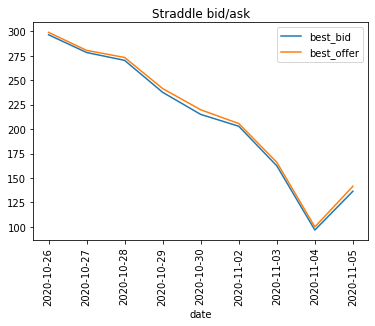

In [15]:
(data[data['optionid']== call_id]['best_bid'] + data[data['optionid']== put_id]['best_bid']).plot(legend=True, rot=90)
(data[data['optionid']== call_id]['best_offer'] + data[data['optionid']== put_id]['best_offer']).plot(legend=True, rot=90, title = "Straddle bid/ask")

#### Figure 2: In our proposed strategy, we would sell the at-the-money straddle on October 29th, which is the implied volatility peak seen in Figure 1. This graph shows the bid/ask of the call and put side of the straddle. As you can see the price plummets after the earnings report is released.

### Sample Analysis: GOOG in week leading up to and following 2020-07-30 earnings report

/tmp/ipykernel_4912/767156435.py:7: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  close_1wk = close.loc[start : end]


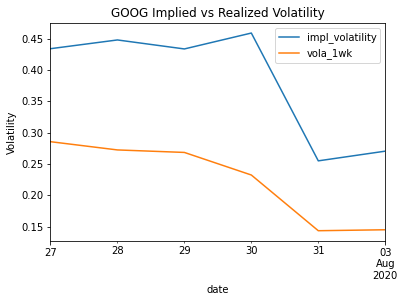

In [16]:
data, closeVols = DataRetriever('GOOG', '2020-07-26', '2020-08-03')
calls, puts = GetATMs(data)
CreateVisual('GOOG', closeVols, calls, puts)

#### Figure 3: GOOG week of earnings - this is a case where implied volatility was significantly higher than realized volatility. Earnings announcement was July 30th after the close - cool to see the implied volatility plummet right after that as the earnings announcement appeared to have little to no impact on the short term realized volatility of the underlying. Implied volatility adjusted quickly as a result.

In [17]:
call_id = option_bbo(calls, data, '2020-07-31')
put_id = option_bbo(puts, data, '2020-07-31')

<AxesSubplot:title={'center':'Straddle bid/ask'}, xlabel='date'>

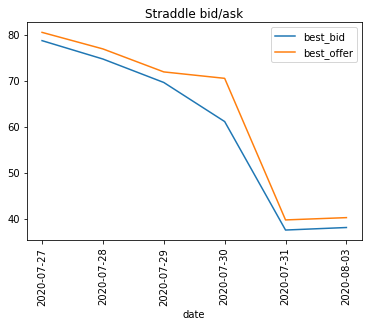

In [18]:
(data[data['optionid']== call_id]['best_bid'] + data[data['optionid']== put_id]['best_bid']).plot(legend=True, rot=90)
(data[data['optionid']== call_id]['best_offer'] + data[data['optionid']== put_id]['best_offer']).plot(legend=True, rot=90, title = "Straddle bid/ask")

#### Figure 4: Here we can see the bid ask spread get very wide on the day of earnings. The price of the straddle drops after earnings, similar to Figure 2. 